# Temperature Forecast Project using ML
Project Description
This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.


In [16]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/08/89/c727fde1a3d12586e0b8c01abf53754707d76beaa9987640e70807d4545f/ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata
  Us

In [17]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [25]:
path="daily-min-temperatures.csv"
data=pd.read_csv(path)
data

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [26]:
time=np.arange(0,3650)
time[-1]

3649

In [27]:
values=data.iloc[:,-1]
values=np.array(values)

In [28]:
values
values[-1]

13.0

# Plot Dataset

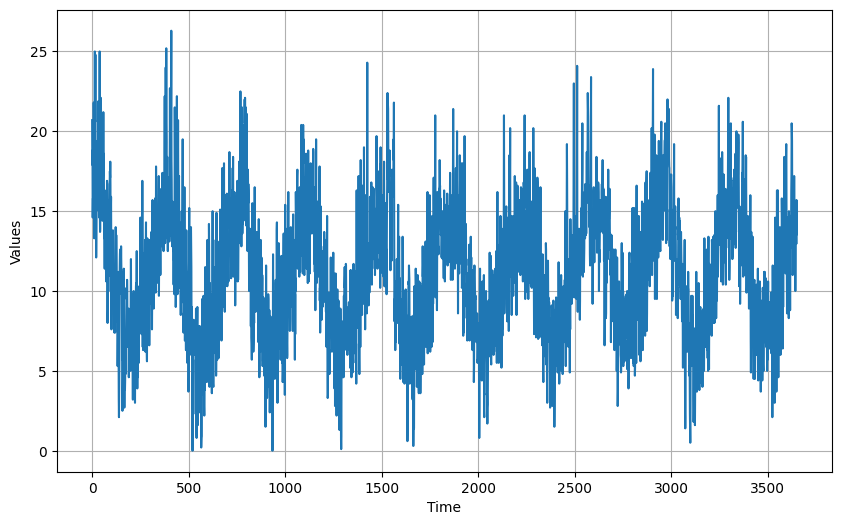

In [29]:
plt.figure(figsize=(10,6))
plt.plot(time,values)
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)

# Processing the data
Splitting Data into Training and Validation

In [30]:
split_time=2500

train_time=time[:split_time]
train_series=values[:split_time]

valid_time=time[split_time:]
valid_series=values[split_time:]

In [31]:
print("length of Train_Time: ",len(train_time))
print("length of Train_Series: ",len(train_series))
print("length of Validation_Time: ",len(valid_time))
print("length of Validation_Series: ",len(valid_series))

length of Train_Time:  2500
length of Train_Series:  2500
length of Validation_Time:  1150
length of Validation_Series:  1150


In [32]:
train_time.shape

(2500,)

# we will feed the data for training by creating a dataset with the appropiate processing steps such as

windowing, flattening, batching and shuffling.

In [33]:
window_size=64
batch_size=256
shuffer_buffer_size = 1000

In [34]:
def windowed_dataset(series, WINDOW_SIZE=window_size, BATCH_SIZE=batch_size, SHUFFER_BUFFER_SIZE=shuffer_buffer_size):
    
    # Create dataset from the series
    dataset=tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset=dataset.window(window_size+1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset=dataset.flat_map(lambda w: w.batch(window_size+1))
    
    # Shuffle it
    dataset=dataset.shuffle(shuffer_buffer_size)
    
    # Split it into the features and labels
    dataset=dataset.map(lambda w: (w[:-1], w[-1]))
    
    # Batch it
    dataset=dataset.batch(batch_size).prefetch(1)
    
    return dataset
train_series_data=windowed_dataset(train_series)
train_series_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

# Defining the Model Architecture

In [39]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74753 (292.00 KB)
Trainable params: 74753 (292.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Adjusting the learning rate
This is only changing the learning rate during the training process to give an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate. hyperparameter optimization

In [42]:
from tensorflow.keras import optimizers

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

model.compile(optimizer=optimizers.SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])


# Training

In [43]:
history=model.fit(train_series_data, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 7s 249ms/step - loss: 10.0989 - mae: 10.5977 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 3s 228ms/step - loss: 9.8468 - mae: 10.3454 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 2s 206ms/step - loss: 9.5987 - mae: 10.0972 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 2s 176ms/step - loss: 9.3809 - mae: 9.8792 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 2s 232ms/step - loss: 9.1590 - mae: 9.6573 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 2s 212ms/step - loss: 8.9104 - mae: 9.4087 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 2s 234ms/step - loss: 8.6113 - mae: 9.1094 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 2s 196ms/step - loss: 8.2435 - mae: 8.7413 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 2s 227ms/step - loss: 7.7866 - mae: 8.2

(0.0001, 10.0, 0.0, 10.0)

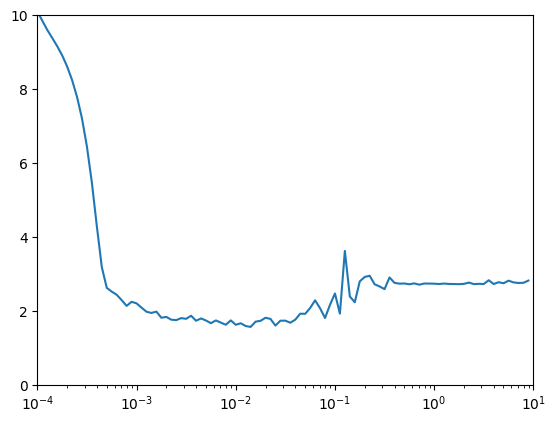

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

# Training with fixed Learning Rate
Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series

In [45]:
model.compile(optimizer=optimizers.SGD(learning_rate=0.0079,momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae'])

In [46]:
history=model.fit(train_series_data, epochs=50)

Epoch 1/50
10/10 [==============================] - 6s 211ms/step - loss: 2.7187 - mae: 3.1853
Epoch 2/50
10/10 [==============================] - 3s 249ms/step - loss: 2.7176 - mae: 3.1844
Epoch 3/50
10/10 [==============================] - 3s 214ms/step - loss: 2.7163 - mae: 3.1831
Epoch 4/50
10/10 [==============================] - 3s 274ms/step - loss: 2.7152 - mae: 3.1818
Epoch 5/50
10/10 [==============================] - 3s 273ms/step - loss: 2.7145 - mae: 3.1811
Epoch 6/50
10/10 [==============================] - 2s 226ms/step - loss: 2.7139 - mae: 3.1804
Epoch 7/50
10/10 [==============================] - 3s 274ms/step - loss: 2.7135 - mae: 3.1800
Epoch 8/50
10/10 [==============================] - 3s 265ms/step - loss: 2.7132 - mae: 3.1796
Epoch 9/50
10/10 [==============================] - 3s 266ms/step - loss: 2.7131 - mae: 3.1793
Epoch 10/50
10/10 [==============================] - 3s 253ms/step - loss: 2.7129 - mae: 3.1790
Epoch 11/50
10/10 [==============================

# Evaluating the forecast

In [47]:
def compute_metrics(true_series, forecast):
    mse=tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae=tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    
    return mse, mae

In [48]:
def model_forecast(model, series, window_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size, shift=1, drop_remainder=True)
    dataset=dataset.flat_map(lambda w: w.batch(window_size))
    dataset=dataset.batch(32).prefetch(1)
    forecast=model.predict(dataset)
    
    return forecast

In [49]:
forecast=model_forecast(model, values, window_size).squeeze()
forecast= forecast[split_time-window_size:-1]

113/113 [==============================] - 3s 19ms/step


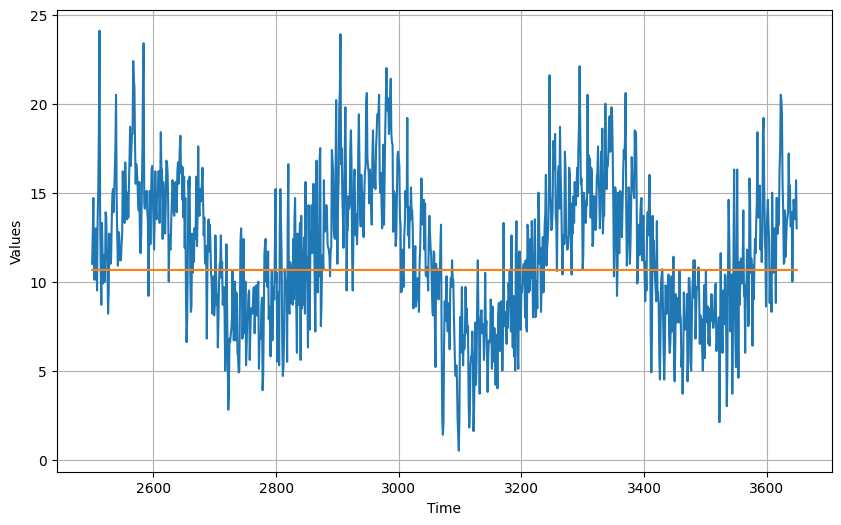

In [50]:
plt.figure(figsize=(10,6))
plt.plot(valid_time,valid_series)
plt.plot(valid_time,forecast)
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)

In [51]:
mse,mae= compute_metrics(valid_series, forecast)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Aboslute Error: {mae:.2f}")

Mean Squared Error: 16.75
Mean Aboslute Error: 3.33
